# Keras Deep Learning Model hyperparameter optimization using talos 

As machine learning progresses throughout the years, Deep learning is becoming more popular machine learning method not only when applying it in image classification tasks but also normal tabular data. Despite all the advantages and hype of deep learning,
it shares one limitation with traditional machine learning models, hyperparameter optimization. The selection of values for the 
hyperparameters of models like logistical regression, k-means, e.t.c are usually based on trial and error till we get a
suitable value for our evaluation metric of our choosing. Deep learning models are no different, In the case of keras, when
we build models, we have to fine-tune hyperparameters like batch size, number of epochs, optimizer used in order to get a acceptable evaluation metric value.Of course, one of the more effcient ways we can go about hyperparameter optimization would be to
use tools like gridsearchCV and randomsearchCV but in the case of deep learning models using keras to build either Recurrent Neural Networks (RNNs) or Convulusion Neural Networks (CNNs),
we can use a hyperparameter optimization library called talos to fine tune these hyperparameters. In a demonstration below, the Heart Disease UCI dataset by from kaggle will be used to demonstrate how talos can be used to make hyperparameter optimization more efficient than compared to the standard trial and error

# Loading the Heart_diease dataset

Importing the neccessary modules for preprocessing

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Loading up the dataset

In [15]:
df = pd.read_csv(r"heart_diease_data.csv")

# Some exploratory data analysis

So as we can see below, the data contains some factors such as age, sex, e.t.c that might affect the 'target' value to be either 0 or 1. 

In [42]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


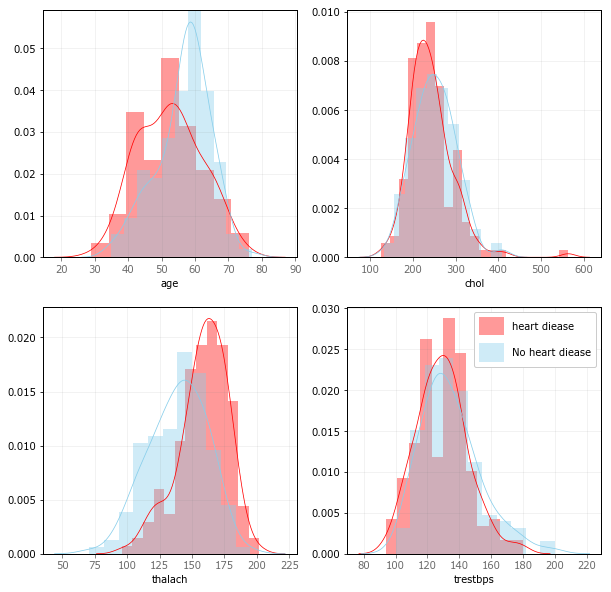

In [47]:
# Some distribution plots

f, axes = plt.subplots(2, 2, figsize=(10, 10)) #sharex=True)
sns.distplot(df["age"][df["target"]==1], color="red", label="heart diease", ax=axes[0, 0])
sns.distplot(df["age"][df["target"]==0] , color="skyblue", label="No heart diease", ax=axes[0, 0])

sns.distplot(df["chol"][df["target"]==1], color="red", label="heart diease", ax=axes[0, 1])
sns.distplot(df["chol"][df["target"]==0] , color="skyblue", label="No heart diease", ax=axes[0, 1])

sns.distplot(df["thalach"][df["target"]==1], color="red", label="heart diease", ax=axes[1, 0])
sns.distplot(df["thalach"][df["target"]==0] , color="skyblue", label="No heart diease", ax=axes[1, 0])

sns.distplot(df["trestbps"][df["target"]==1], color="red", label="heart diease", ax=axes[1, 1])
sns.distplot(df["trestbps"][df["target"]==0] , color="skyblue", label="No heart diease", ax=axes[1, 1])
plt.legend()

plt.show()


<function matplotlib.pyplot.show>

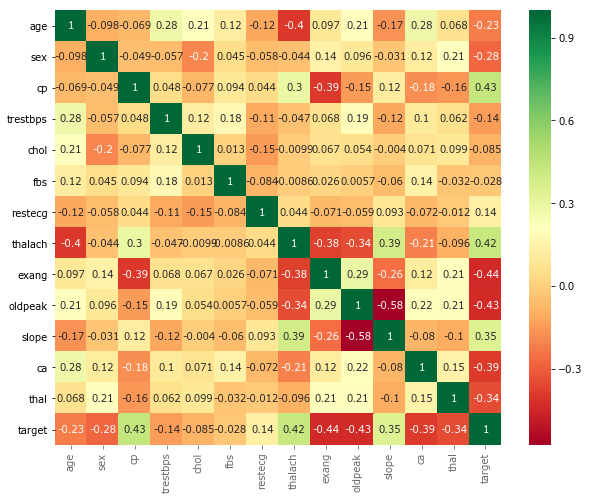

In [49]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn') 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show

# Well, there is nothing too striking in the correlation heatmap

# Some data preprocessing

Importing Keras modules

In [3]:
from keras.optimizers import SGD 

from keras.utils import np_utils
from keras.models import Sequential # The common deep learning network
from keras.layers.core import Dense, Activation
from keras.activations import relu, elu, selu, sigmoid, exponential, tanh

C:\Users\HYK\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Y will be the targets 0 or 1 under the targets col while X will be the data in the rest of the cols which we will use as factors that we assume will affect the outcome of the target 

In [4]:
X = df.drop("target",axis=1)
y = df["target"].values

Like all modeling practises, we need to split the data up into the training set (the data that we will use to train the model with) and the testing set (the data that we will use to test the accuracy of the model). In this case, I will be spliting it into a 75% (training set), 25% (testing set) ratio

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

Lets inspect the shape of our training data

In [6]:
X_train.shape

(227, 13)

In [41]:
y_train.shape

(227,)

# Scalling the data

As for most datasets out there, it is necessary to scale the data before fitting it with our model

In [7]:
scaler = StandardScaler()

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.fit_transform(X_test)

For my keras model, there is one parameter that I do not want to change, that is the number of classes that my model has to predict, hence, I will set a variable to it

In [9]:
NB_CLASSES = 2 # Number of classes to predict

Binarising the target variables 


In [10]:
y_train_new = np_utils.to_categorical(y_train,NB_CLASSES)
y_test_new = np_utils.to_categorical(y_test,NB_CLASSES)

# Import talos

Importing talos which can be use as hyperparameter optimization for our keras model

In [11]:
import talos as ts

Now, I will be setting the values that I want to test out for the hyperparameters of my model. In all I will be setting 6 different hyperparameters with a set of values that I want to test out 

In [12]:
from keras.activations import relu, elu, selu, sigmoid, exponential, tanh

p = {
    'activation': [relu, elu, selu, sigmoid, exponential, tanh],
    'batch_size': [64,128,256],
    'First_Neron' : [64,128,256],
    'Second_Neron' : [64,128,256],
    'Third_Neron' : [64,128,256],
    'epochs': [50,100,150,200]
}

# Building our keras model for hyperparameter optimization

For our model, I've a function that will build, compile and fit the model with the training data, The model have has to be of a standard structure before testing in terms of the number of hidden layers. In this case, I've decided to use 3 dense layers only. However, If you were to look closer, this model is a bit different from how a keras model is normally builded as the hyperparameters that I've decided to finetune are fitted with the variable 'params' which will then be scanned by talos.

In [13]:
def get_model_talos(X_train,y_train,X_test,y_test,params):
    model = Sequential() # load the sequential model
    model.add(Dense(NB_CLASSES, input_shape=(13,), activation=params['activation'])) # add a dense layer
    model.add(Dense(params['First_Neron'], input_shape=(13,), activation=params['activation']))
    model.add(Dense(params['Second_Neron'], input_shape=(13,), activation=params['activation']))
    model.add(Dense(params['Third_Neron'], input_shape=(13,), activation=params['activation']))
    model.add(Dense(NB_CLASSES, input_shape=(13,))) # add a dense layer
    model.add(Activation('softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])
    out = model.fit(X_train, y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_data=(X_test,y_test),
                    verbose=0)
            
    return out, model

Once we have created our model, we use Scan() to perform hyper parameter optimization on the 6 hyperparameters that I've selected and the values that I want to test it out on.

In [14]:
t = ts.Scan(x=X_train_scaled, y=y_train_new, x_val=X_test_scaled, y_val=y_test_new, params=p, model=get_model_talos)

100%|██████████| 1944/1944 [45:18<00:00,  1.33s/it] 


Scan Finished!


As you can see, the process will take quite long so, if you were to try this out, I would recommend going for the a coffee break or 2 while we wait for the tunning to complete.

Note that talos works the same as gridsearchCV or RandomSearchCV, the more hyperparameter values you want to test out, the more time it will take to finetune those parameters

Once the tunning is done, we want to see the results of the tunning, To do this, I will be using Reporting() from talos

In [16]:
from talos import Reporting
r = Reporting(t)

The high() returns the highest evaluation metric in your hyperparameter optimization, In my case, it would be the validation accuracy 

In [17]:
r.high()

'0.8947368452423498'

Hmmm, not too bad, I think I'm going to stick with this result

Lets see what round of optimization is that

In [22]:
r.rounds2high()

271

I would also like to see remaining model parameters that came close to the highest validation accuracy as well

In [19]:
frame = t.data

In [21]:
frame[frame["val_acc"] >= '0.89']

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,First_Neron,Second_Neron,Third_Neron,epochs
163,200,0.3186315596103668,0.8947368264198303,0.4012680183685824,0.8325991084397102,<function tanh at 0x0000024DD65A4D08>,128,128,256,128,200
271,200,0.35769385569973994,0.8947368452423498,0.3711878898910489,0.8414096934679847,<function elu at 0x0000024DD65A4A60>,64,64,256,128,200
291,150,0.31931535036940323,0.8947368389681766,0.34239984819017316,0.8854625571666835,<function selu at 0x0000024DD65A4AE8>,64,128,128,128,150
521,150,0.38683407400783737,0.8947368452423498,0.3606863164954249,0.8502202664177848,<function selu at 0x0000024DD65A4AE8>,64,64,64,64,150
532,150,0.3436183192228016,0.8947368452423498,0.35592788996150315,0.8634361246608953,<function tanh at 0x0000024DD65A4D08>,64,128,128,256,150
660,150,0.33683972295961884,0.8947368452423498,0.38469195536579853,0.8105726890626983,<function selu at 0x0000024DD65A4AE8>,64,64,256,128,150
711,200,0.3951923015870546,0.8947368452423498,0.38740209178252366,0.8149779759314617,<function tanh at 0x0000024DD65A4D08>,64,64,64,64,200
790,150,0.3447280196767104,0.8947368452423498,0.3988974573591207,0.8193832625376496,<function tanh at 0x0000024DD65A4D08>,64,128,256,128,150
819,150,0.37289270601774516,0.8947368452423498,0.39701531925915623,0.8149779756688862,<function elu at 0x0000024DD65A4A60>,64,128,64,256,150
1347,200,0.3597933351993561,0.8947368452423498,0.36548000298407635,0.8634361246608953,<function selu at 0x0000024DD65A4AE8>,64,64,256,64,200


test number 1864 list of parameters

# Deploying the model using talos

I'm statisfied with the validation accuracy result above so I'm going to save my model details so that I can use it again in the future.
To do this, I'm going to use Deploy() and Restore() to save and load up my model using talos
Note that the Deploy() will automatically take in the best model parameters for your model based on your specified evaluation metric when tunning the hyperparameters earlier.

In [26]:
ts.Deploy(t, 'heart_diease_predmodel');

Deploy package heart_diease_predmodel have been saved.


In [28]:
heart_diease_predmodel = ts.Restore('heart_diease_predmodel.zip')

Once that is done, I can use the model to predict my target values by inputing my own X values. As I'm feeling a bit lazy, I'm going to reuse by X_test data as a demonstration

In [40]:
heart_diease_predmodel.model.predict_classes(X_test_scaled)

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

Of course, I can try and continue to raise the accuracy of the model by trying out more possible hyperparameter choices, doing some feature engineering or changing the structure of my model but all in all, I think talos demonstrated the efficiency in which a keras model can be fine tunned and builded.

In conclusion, I just want to thank the creators of talos for such an awesome library. It really makes hyperparameter optimization much more efficient for deep learning models. This is my first kernel published on hyperparameter optimization on deep learning models as well as my first kernel on Kaggle and any form of constructuctive feedbacks are appreciated. Thank You